In [1]:
import sys
sys.path = ['', '/Users/panda/miniconda2/lib/python27.zip',
            '/Users/panda/miniconda2/lib/python2.7', '/Users/panda/miniconda2/lib/python2.7/plat-darwin', 
            '/Users/panda/miniconda2/lib/python2.7/plat-mac', 
            '/Users/panda/miniconda2/lib/python2.7/plat-mac/lib-scriptpackages', 
            '/Users/panda/miniconda2/lib/python2.7/lib-tk', '/Users/panda/miniconda2/lib/python2.7/lib-old', 
            '/Users/panda/miniconda2/lib/python2.7/lib-dynload', '/Users/panda/miniconda2/lib/python2.7/site-packages', 
            '/Users/panda/miniconda2/lib/python2.7/site-packages/setuptools-19.6.2-py2.7.egg']

import seaborn as sns
import json
import pandas as pd
import numpy as np
from pandas.io import data
from pandas import Series, DataFrame
import nltk
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
import sklearn.datasets as sk_data
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns

import numpy as np


from scipy.spatial.distance import pdist, squareform
    
import gmplot
import collections


%matplotlib inline



/Users/panda/miniconda2/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Class Station
This is the class to aggregate data. Latter we will use its location information to draw our results on map

In [2]:
'''
Cluster is based on each station's information, so this class is the abstract of station.

'''
class Station(object):
    
    # @station_id int
    # Use an integer number to initilize an station instance
    def __init__(self, station_id):
        self.station_id = station_id
        self.features = ['TEMP', 'DEWP', 'SLP', 'STP',
                         'VISIB','WDSP','MXSPD',
                         'GUST','MAX','MIN','SNDP','FOG',
                        'RAIN','SNOW','HAIL','THUNDER','TORNADO']
        
        self.missingValue = [9999.9, 9999.9, 9999.9, 9999.9,
                            999.9, 999.9, 999.9,999.9,
                             9999.9, 9999.9,999.9,
                            -1,-1,-1,-1,-1,-1]
        
        self.META = {}
        self.data = {}
        self.location = [0.0,0.0]
        
        for x in xrange(1,13,1):
            self.META[x] = {}
            self.data[x] = {}
            for name in self.features:
            
                self.META[x][name] = 0
                self.data[x][name] = 0
    
        
    
    # @month int
    # @data dict, must include all the fields that list in self.features
    # This method will filt all the default or missing value
    def inputData(self, month, data):
        
        for i in xrange(len(self.features)):
            name = self.features[i]
            
            rs = data.get(name, None)
            
            if rs != None and rs != self.missingValue[i] :
                self.data[month][name] += rs
                self.META[month][name] += 1
    
    # @month int
    # return the summary for each month. This is an inner function
    def summaryByMonth(self, month):
        exp = ['FOG','RAIN','SNOW','HAIL','THUNDER','TORNADO']
        result = []
        for kind in self.features:
            
            if kind in exp:
                result.append(self.data[month][kind])
            else:
                v = 0.0
                if self.META[month][kind] != 0:
                    v = (self.data[month][kind]+0.0) / (self.META[month][kind])
                result.append(v)
        return result
                    
    
    # For each station, this method return the summary.
    # This method return the feature vector for analyzing
    def summaryFeatureVector(self):
        rs = []
        for x in xrange(1,13,1):
            rs.extend(self.summaryByMonth(x))
        return rs
    
    # This method return method dictinary
    def summaryByDict(self):
        rs = {}
        for x in xrange(1,13,1):
            rs[x] = self.summaryByMonth(x)
        return rs



### Other helper functions


In [3]:

# Some of the data may contains one bit flag like '*,A,I' and so on
# This method will pop this value if it contains one bit tag
def extractNumber(s):
    last = s[-1]
    l = len(s)
    if ord(last) >= ord('0') and ord(last) <= ord('9'):
        return s
    else:
        return s[0:l-1]

# 6 special weather are represented by 6-bits string in the raw data
# Here I extract them and write the value to its coresponded field  
def extractSpecialWeather(d, s):
    w = ['FOG', 'RAIN', 'SNOW', 'HAIL', 'THUNDER', 'TORNADO']
    if len(s) != 6 :
        print 'alert! not well-formed data'
    
    for i in xrange(6):
        if s[i] == '1':
            d[w[i]] = 1
        else:
            d[w[i]] = 0
    return d
    
# Input the joined data file path
# Read line by line and build a dict with all stations
def buildStationDict(filepath):
    rs = {}
    f = open(filepath)
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        station_id = int(data[0])
        month = data[2][4:6]
        month = int(month)
        fdict = {}
        i = 0
        for x in xrange(3, 17, 2):
            fdict[names[i]] = float(data[x])
            i+=1
        fdict['GUST'] = float(data[16])
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        
        
        fdict['MAX'] = float(maxV)
        fdict['MIN'] = float(minV)
        fdict['SNDP'] = float(data[20])
        fdict = extractSpecialWeather(fdict, data[21])
        
        if rs.get(station_id) == None:
            p = Station(station_id)
            rs[station_id] = p
        p = rs[station_id]
        p.location = [data[-2],data[-1]]
        p.inputData(month, fdict)
    return rs
        
        

        
# Convert raw data location format
# For the latitude and logitude, E,N will be positive while W,S will be negative
def getLocation(loc):
    rs = [0,0]
    
    la = loc[0]
    lo = loc[1]
    
    end_la = la[-1]
    end_lo = lo[-1]
    
    l1 = len(la)
    l2 = len(lo)
    
    la = la[0:l1-1]
    lo = lo[0: l2-1]
    
    if end_la == 'N':
        rs[0] = float(la) / 100.0
    else:
        rs[0] = float(la) / -100.0
    
    if end_lo == 'E':
        rs[1] = float(lo) / 100.0
    else:
        rs[1] = float(lo) / -100.0
    return rs    
    
# @data pandas.DataFrame  Must contains 3 feilds, 'latitude','longitude','label'
# @filepath str specify where you want to store the result
# @colors, If you have more than 6 labels, you should specify your own color list
def showOnMap(data, filepath,colors = []):
    gmap = gmplot.GoogleMapPlotter(36.161517,-115.164011,16)

    la = list(data['latitude'])
    lo = list(data['longitude'])
    label = list(data['label'])
    
    if len(colors) == 0:
        colors = ['#ff0000','#00ff00','#0000ff','#ffff00','#ff00ff','#00ffff']
    draw_la = collections.defaultdict(list)
    draw_lo = collections.defaultdict(list)

    kind = len(colors)
    for i in range(len(label)):
        try:
            color = colors[int(label[i]) % kind]
        
            draw_la[color].append(la[i])
            draw_lo[color].append(lo[i])
        except:
            print i
            print label[i]

    for each in draw_la.keys():
        gmap.scatter(draw_la[each], draw_lo[each], each, size=10000, marker=False)
    gmap.draw(filepath)   

    
# @data pandas.DataFrame
# @n_clusters  How many clusters you want
# @plot_graph Only to be True if you want to plot the graph, especially when there are only 2 labels
def GMMCluster(data, n_clusters = 3, plot_graph = False):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    print n_clusters
    gmm = mixture.GMM(n_components=n_clusters, covariance_type='diag')
    gmm.fit(data)
    y_pred = gmm.predict(data)
    
    if plot_graph:   
        plt.scatter(data[:, 0], data[:, 1], s=10,color=colors[y_pred].tolist(), alpha=0.8)
        plt.show()
    return y_pred


### Build the station dictionary

In [ ]:
m = buildStationDict('data_with_location.csv')

### Convert station to feature vector

In [ ]:
features = []
locations = []    

for station_id in m.keys():    
    station = m[station_id]
    locations.append( getLocation( station.location) )
    features.append(station.summaryFeatureVector())
    

data = np.array(features)


### Do GMM cluster
Do GMM cluster and show it on the map

In [ ]:
labels = GMMCluster(data, 15)

In [ ]:
las = []
los = []
label = []
i = 0
for each in locations:
    las.append(each[0])
    los.append(each[1])
    label.append(labels[i])
    i+=1

rs = {'latitude':las, 'longitude':los, 'label':label}

df = pd.DataFrame(rs)

print df.columns

colors = ['#000000','#0000FF','#8A2BE2',
          '#5F9EA0','#7FFF00','#FF7F50',
          '#DC143C', '#00FFFF','#006400',
         '#8B008B', '#556B2F','#483D8B',
         '#9400D3','#FFD700','#FF4500']

    

showOnMap(df, 'GMM-cluster.html')

## Next part SVM

- First part is the helper functions
- Use SVM to predict special weather
- Draw ROC curve to show our result

In [18]:
import collections

# @weather_str 6-bits string. 
# @in_detail if True, return lables from 0 to 63. If False, return boolean labels
def getSpecialWeatherLabel(weather_str, in_detail = False):
    
    label = 0
    for x in range(6):
        weight = 1 << x
        v = int(weather_str[x])
        label += weight*v
    
    if in_detail:
        return label
    else:
        return label == 0
        

# For each row in the file, get its features and labels
# @filepath input data file path
# @return type: pandas.DataFrame
def extractClassificationTable(filepath):
    f = open(filepath)
    
    fdict = collections.defaultdict(list)
    
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        #get month
        month = data[2][4:6]
        month = int(month)
        
        fdict['MONTH'].append(month)
        
        i = 0
        for x in xrange(3, 17, 2):
            fdict[names[i]].append(float(data[x]))
            i+=1
        fdict['GUST'].append(float(data[16]))
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        
        
        fdict['MAX'].append(float(maxV))
        fdict['MIN'].append(float(minV))
        fdict['SNDP'].append(float(data[20]))
        fdict['LABEL'].append(getSpecialWeatherLabel(data[21], False))
        
        lati, logi = getLocation([data[-2],data[-1]])
        fdict['LAT'].append(lati)
        fdict['LOG'].append(logi)
    
    frame = pd.DataFrame(fdict)
    
    return frame
        


    
    
    
    

### Build dataset

In [19]:
classify_dataframe = extractClassificationTable('data_narrow.csv')
weather_labels  =classify_dataframe.pop('LABEL')
print classify_dataframe.shape
print classify_dataframe.head(2)
print classify_dataframe.columns

(23284, 14)
   DEWP   GUST    LAT  LOG   MAX   MIN  MONTH  MXSPD     SLP   SNDP     STP  \
0  20.8  999.9  70.56 -8.4  28.2  22.3      2   27.2  1004.7  999.9  1003.5   
1  12.2  999.9  70.56 -8.4  19.9  14.7      3   21.4  1015.9  999.9  1014.6   

   TEMP  VISIB  WDSP  
0  24.9    4.1  21.9  
1  18.6    9.9  13.5  
Index([u'DEWP', u'GUST', u'LAT', u'LOG', u'MAX', u'MIN', u'MONTH', u'MXSPD',
       u'SLP', u'SNDP', u'STP', u'TEMP', u'VISIB', u'WDSP'],
      dtype='object')


### Split the dataset to train and test part

In [29]:

y = weather_labels.values
X = classify_dataframe.values

X, y = utils.shuffle(X, y, random_state=1)
print X.shape
print y.shape
print y
train_set_size = 5000
X_train = X[:train_set_size]  # selects first 10000 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 10000 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape


(23284, 14)
(23284,)
[False  True  True ..., False  True False]


### Do SVM classification and show its accuracy

In [37]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

svc = svm.SVC(kernel='linear', max_iter=10000)
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print "Accuracy of SVM test set:", svc.score(X_test, y_test)


Accuracy of SVM test set: 0.556606869394


### Plot ROC curve to evaluate our result
When you try to plot ROC curve, make sure your label is binary

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

classifier = OneVsRestClassifier(svc)

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

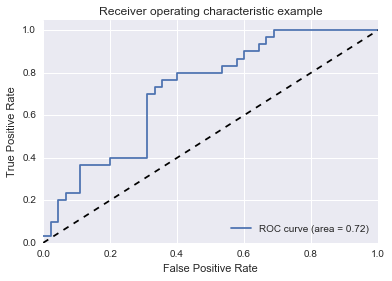

In [45]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()